In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pandas as pd
from pymc.Matplot import plot as pmplot
from matplotlib.ticker import StrMethodFormatter

import scipy.stats as sps


sns.set()

[410.]
 [-----------------100%-----------------] 100000 of 100000 complete in 13.7 sec
373.1903481564094
383.30317035737
0.00824
0.00824


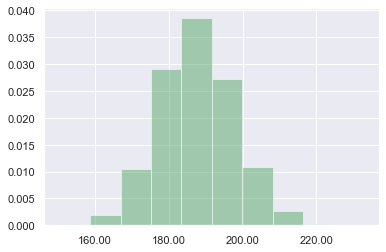

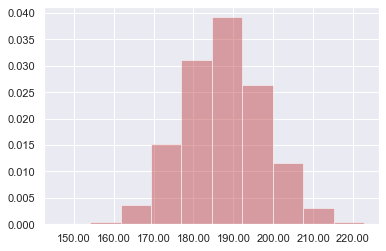

In [2]:
# with data - posterior distribution

x1 = pm.Normal('x1',mu=185,tau = 1 / 10 ** 2)
x2 = pm.Normal('x2',mu=185,tau = 1 / 10 ** 2)

obs_sigma = pm.Uniform('obs_sigma',0,100)

nr_pairs = 1
data = np.ones(nr_pairs) * 410 # combined length of two people
print (data)

@pm.deterministic
def two_tall_people(x1=x1,x2=x2):
    out = np.ones(len(data)) * (x1 + x2) 
    return out

obs = pm.Normal('obs',two_tall_people,1 / obs_sigma ** 2,observed=True,value=np.array(data))

model = pm.Model([x1,x2,two_tall_people,obs,obs_sigma])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

sample = mcmc.sample(100000,50000,2)

x1_post = mcmc.trace('x1')[:]
x2_post = mcmc.trace('x2')[:]
two_tall_post = mcmc.trace('two_tall_people')[:]


#pmplot(x1_post,'x1')
#pmplot(x2_post,'x2')
#pmplot(two_tall_post,'two_tall_people')

plt.figure()
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
#plt.ticklabel_format(useOffset=False)
plt.hist(x1_post,color='g',alpha=0.5,density=True)
plt.figure()
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
#plt.ticklabel_format(useOffset=False)
_ = plt.hist(x2_post,color='r',alpha=0.5,density=True)
print()
print (x1_post.min() + x2_post.max())
print (x1_post.max() + x1_post.min())

print ((x1_post + x2_post >= 410).sum() / len(x1_post))
print ((x1_post + x2_post >= 410).mean())

In [ ]:
#without data - prior distribution
# x1 + x2 = 410
# x2 = 410 - x1
x1 = pm.Normal('x1',mu=180,tau = 1 / 10 ** 2)
x2 = pm.Normal('x2',mu=410-x1,tau = 1 / 10 ** 2)

model = pm.Model([x1,x2])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
sample = mcmc.sample(100)

x1_trace = mcmc.trace('x1')[:]
x2_trace = mcmc.trace('x2')[:]

plt.hist(x1_trace,density=True,color='g',alpha=0.6)
plt.hist(x2_trace,density=True,color='r',alpha=0.6)

plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(x1_trace,color='g')
plt.subplot(312)
plt.plot(-x2_trace,color='orange')
plt.subplot(313)
plt.plot(x2_trace,color='r')

In [ ]:
# trap of averages with low sample sizes - hacker book

nr_counties = 5000
p = 0.01

def gen_population():
    pop = pm.rdiscrete_uniform(100,10000,size=nr_counties)
    return pop

def gen_dead(popsize):
    l = pm.rbernoulli(p=p,size=popsize)
    return l

pop_df = pd.DataFrame({'population':gen_population()})
pop_df.index.name='country_nr'
pop_df.sort_values('population',inplace=True)
pop_df.reset_index(inplace=True)
pop_df.head()



In [ ]:
pop_df['is_dead'] = pop_df['population'].apply(gen_dead)
pop_df['mean_dead'] = pop_df['is_dead'].apply(np.mean)
pop_df.head(40)

In [ ]:


plt.figure(figsize=(18,12))
plt.title('Law of SMALL Numbers - beware of using averages of small samples!')
plt.scatter(pop_df['population'],pop_df['mean_dead'],facecolor='none',edgecolor='crimson')
plt.xlabel('country population size')
plt.ylabel('country mean ratio of dead')
plt.axhline(p,ls='dashed',color='orange',lw=3,label='True ratio of dead')
plt.axhline(pop_df['mean_dead'].mean() - pop_df['mean_dead'].std(),color='lime',ls='dashed',label='1 std')
plt.axhline(pop_df['mean_dead'].mean() + pop_df['mean_dead'].std(),color='lime',ls='dashed',label='1 std')

plt.legend(loc='upper right')

In [ ]:
# observed vs samples

days = 10
observed_per_day = 100
samples_per_day = 10

observed = np.zeros((days,observed_per_day))
samples = np.zeros((days,samples_per_day))

print (observed.shape)
print (samples.shape)

for d in range(0,days):
    observed[d] = np.random.normal((d + 1) * 10 ,5,observed_per_day)
    samples[d] = np.random.normal((d + 1) * 10, 5,samples_per_day)
    samples[d] += np.random.randint(1,5,samples_per_day)

### samples and observed are two dimensional with same nr of rows
def observed_vs_samples(observed,samples):
    
    observed_mean_per_day = np.mean(observed,axis=1)
    sample_mean_per_day = np.mean(samples,axis=1)

    df = pd.DataFrame({'observed_mean' : observed_mean_per_day,
                      'samples_mean' : sample_mean_per_day})

    df.index.name= 'day'
    df['sample_ci_low'] = np.percentile(samples,[5.5,94.5],axis=1)[0]
    df['sample_ci_high'] = np.percentile(samples,[5.5,94.5],axis=1)[1]

    plt.figure(figsize=(18,12))
    plt.errorbar(df['observed_mean'],df['samples_mean'],
                 np.array(np.abs(df['samples_mean'] - df['sample_ci_low']),
                          np.abs(df['samples_mean'] - df['sample_ci_high'])),
                fmt='o')
    
    plt.xlabel('observed mean by each day')
    plt.ylabel('sample mean by each day')
    print (df)
    
_ = observed_vs_samples(observed,samples)

In [ ]:
resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

for i in range (7):
    print (i,resample_period[today],yesterday(today))
    
today

In [ ]:
some_dates = pd.date_range('2020-01-01','2020-01-31')
start = pd.to_datetime('2020-01-10')
end = pd.to_datetime('2020-01-15')

df = pd.DataFrame(index=some_dates,data=range(len(some_dates)))
df.loc['2020-01-05' : '2020-01-10']

In [ ]:
# Water Land

#conjecture : assume prior proportion water is uniform discrete [0..1] with 0.1 steps

conjecture = np.zeros((6,4))
conjecture

In [ ]:
#McElreath Water 

size = 10000
p_grid = np.linspace(0,1,size)

#prior = np.ones_like(p_grid) #uniform prior
#prior = sps.beta.pdf(p_grid,80,40)
prior = sps.norm.pdf(p_grid,0.5,0.3)

plt.figure(figsize=(18,12))

for nr_water in range(1,2):
    likelihood = sps.binom.pmf(6,n=9,p=p_grid) #must be a pmf/pdf, not samples! 
    posterior = prior * likelihood 
    posterior = posterior / posterior.sum()

    _= plt.plot(p_grid,posterior)



In [ ]:
# lognormal

data = np.random.lognormal(1,0.25,10000)
data = np.power(np.e,data)
data_mean = data.mean()

plt.hist(data,bins=20)
plt.axvline(data.min(),color='r',ls='dashed',label='min')
plt.axvline(data.max(),color='r',ls='dashed',label='max')
plt.axvline(data.mean(),color='orange',ls='dashed',label='mean')
plt.axvline(np.median(data),color='lime',ls='dashed',label='median')
plt.axvline(data.mean() - data.std(),color='navy',ls='dashed',label='std')
plt.axvline(data.mean() + data.std(),color='navy',ls='dashed',label='std')


plt.legend(loc='upper center')

plt.figure()
log_data = np.log10(data)
plt.axvline(log_data.min(),color='r',ls='dashed',label='min')
plt.axvline(log_data.max(),color='r',ls='dashed',label='max')
plt.axvline(log_data.mean(),color='orange',ls='dashed',label='mean')
plt.axvline(np.median(log_data),color='lime',ls='dashed',label='median')
plt.axvline(log_data.mean() - log_data.std(),color='navy',ls='dashed',label='std')
plt.axvline(log_data.mean() + log_data.std(),color='navy',ls='dashed',label='std')

plt.legend(loc='upper center')
plt.hist(log_data)

In [ ]:
# parametric-non-parametric vs Bayes
# https://onlinelibrary.wiley.com/doi/pdf/10.1111/anae.13666

#data1 = np.array([1,2,3])
data1 = np.array([5,7,9])
#data2 = np.array([4,5,6])
data2 = np.array([1453,1720,1785])

alpha_1 = 1 / data1.mean()
alpha_2 = 1 / data2.mean()

lambda_1 = pm.Exponential('lambda_1',alpha_1)
lambda_2 = pm.Exponential('lambda_2',alpha_2)

obs_1 = pm.Poisson('obs_1',lambda_1,observed=True,value=data1)
obs_2 = pm.Poisson('obs_2',lambda_2,observed=True,value=data2)

model = pm.Model([lambda_1,lambda_2,obs_1,obs_2])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

sample = mcmc.sample(50000,10000,2)

lambda_1_post = mcmc.trace('lambda_1')[:]
lambda_2_post = mcmc.trace('lambda_2')[:]

pmplot(lambda_1_post,'lambda_1')
pmplot(lambda_2_post,'lambda_2')

plt.figure(figsize=(18,12))
plt.title('Bayesian inference on the Non-parametric problem presented '\
          'in \n https://onlinelibrary.wiley.com/doi/pdf/10.1111/anae.13666 \n posterior probabily group1 > group2: {:.2f}'.format(
(lambda_1_post > lambda_2_post).mean()))

plt.hist(lambda_1_post,density=True,color='g',histtype='stepfilled',alpha=0.6,label='values 5,7,9')
plt.hist(lambda_2_post,density=True,color='r',histtype='stepfilled',alpha=0.6,label='values 1453,1720,1785')
plt.legend(loc='upper right')
plt.ylabel('density')
plt.xlabel('Expected Value for Rank in group')

print ((lambda_1_post > lambda_2_post).mean())
print ((lambda_1_post > lambda_2_post).sum() / lambda_1_post.size)

plt.savefig('Bayesian_ex_of_p_value_bashing_no_ranks.jpg',format='jpg')

In [ ]:
# apply
# DataFrame.apply operates on entire rows or columns at a time.

# DataFrame.applymap, Series.apply, and Series.map operate on one element at time.

def standardize(x):
    return (x - x.mean()) / x.std()

def standardize2(x,mean,std):
    return (x - mean) / std

df = pd.DataFrame({'A': range(0,3),
                  'B': range(3,6),
                  'C': range(6,9)})

print (df)
print (df.apply(np.mean))
print (df.apply(standardize))
# but df['A'].apply(standartize) fails b/c on series it operates on individual elements

print (standardize(df['A']))

print (standardize2(df['A'],df['A'].mean(),df['A'].std()))

print (df['A'].apply(standardize2,args=(df['A'].mean(),df['A'].std())))